In [47]:
# Import package for Data Extraction, Loading & Transformation
import pandas as pd
import requests
import seaborn as sns
import hvplot.pandas

# Import dotenv package for setting environment variables 
from dotenv import load_dotenv

# Import os package
import os

# Set environment variables from the .env in the local environment
load_dotenv()

# Retrieve API key and store as Python variable
api_key = os.getenv('API_KEY')
type(api_key)

str

In [25]:
# ETFs and Ticker Data for Sectoral Performance Analysis

ticker_name_dict = {'XIU':['iShares S&P/TSX 60 Index ETF','TSX_60'],
                    'XST':['iShares S&P/TSX Capped Consumer Staples Index ETF','Consumer_Staples'],
                    'XHC':['iShares Global Healthcare Index ETF','Health'],
                    'XRE':['iShares S&P/TSX Capped REIT Index ETF','Real_Estate'],
                    'XUT':['iShares S&P/TSX Capped Utilities Index ETF','Utilities'],
                    'CEW':['iShares Equal Weight Banc & Lifeco ETF','Financial_Services'],
                    'TRVL':['Harvest Travel & Leisure Index ETF','Travel_Leisure'],
                    'XGD':['iShares S&P/TSX Global Gold Index ETF','Gold']}

ticker_df = pd.DataFrame.from_dict(ticker_name_dict,orient='index',
                                   columns=['ETF','Sector'])

ticker_df                                       

,ETF,Sector
XIU,iShares S&P/TSX 60 Index ETF,TSX_60
XST,iShares S&P/TSX Capped Consumer Staples Index ETF,Consumer_Staples
XHC,iShares Global Healthcare Index ETF,Health
XRE,iShares S&P/TSX Capped REIT Index ETF,Real_Estate
XUT,iShares S&P/TSX Capped Utilities Index ETF,Utilities
CEW,iShares Equal Weight Banc & Lifeco ETF,Financial_Services
TRVL,Harvest Travel & Leisure Index ETF,Travel_Leisure
XGD,iShares S&P/TSX Global Gold Index ETF,Gold


In [26]:
# Creating New Directory to Save Data

os.makedirs('./Output', exist_ok = True)
ticker_df.to_csv('./Output/ticker.csv')

In [28]:
# Monthly Time-Series Data to uderstand the structure

gold_etf_url = url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol=XGD.TRT&outputsize=full&apikey={api_key}&datatype=csv'
sample_r = requests.get(url)
print(sample_r)
xgd_df = pd.read_csv(url)
display(xgd_df.head())
display(xgd_df.tail())


<Response [200]>


,timestamp,open,high,low,close,volume
0,2024-01-23,17.82,18.01,15.95,16.59,5331893
1,2023-12-29,18.14,18.62,16.72,17.79,8091600
2,2023-11-30,16.90,18.27,16.10,18.20,11343900
3,2023-10-31,15.69,17.92,15.31,16.84,9186100
4,2023-09-29,17.36,17.54,15.62,15.84,6780900


,timestamp,open,high,low,close,volume
223,2005-06-30,45.29,50.85,45.25,49.80,14888000
224,2005-05-31,44.65,46.23,41.58,45.46,6137600
225,2005-04-29,48.45,49.02,43.74,44.69,22728400
226,2005-03-31,51.95,54.12,47.26,48.51,18359200
227,2005-02-28,49.01,54.15,47.45,52.33,15954800


In [36]:
# Using Function to extract data using APIs and save as csvfiles

# Creating a List of ETF Tickers
etf_list = ticker_df.index.to_list()
 

def extract_api_data(data_list):
    df_list = []
    for item in data_list:
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={item}.TRT&outputsize=full&apikey={api_key}&datatype=csv'
        r = requests.get(url)
        df = pd.read_csv(url)
        df['timestamp'] = df['timestamp'].str[:4]                           # Extracting Year from timestamp
        item_df = df.rename(columns={'close': f'{item}','timestamp':'Year'})# Renaming Columns
        item_df = item_df.groupby('Year').mean()                            # Calculating Average Yearly Price
        df_list.append(item_df)
    
    raw_df = pd.concat(df_list, axis=1)
    return(raw_df)

raw_etf_df = extract_api_data(etf_list)

combined_etf_df = raw_etf_df.drop(columns=['open','high','low','volume'],axis=1)

combined_etf_df.to_csv('./Output/etf_annual_data.csv')

display(combined_etf_df.head())
display(combined_etf_df.tail())


,XIU,XST,XHC,XRE,XUT,CEW,TRVL,XGD
Year,,,,,,,,
2005,57.660909,NaN,NaN,12.799045,NaN,NaN,NaN,51.521818
2006,68.781667,NaN,NaN,14.847333,NaN,NaN,NaN,75.980833
2007,79.343333,NaN,NaN,16.218783,NaN,NaN,NaN,74.636667
2008,54.714167,NaN,NaN,12.224200,NaN,7.15790,NaN,55.285833
2009,15.463333,NaN,NaN,9.569833,NaN,6.38115,NaN,20.005000


,XIU,XST,XHC,XRE,XUT,CEW,TRVL,XGD
Year,,,,,,,,
2020,24.128333,63.537500,53.970833,15.976717,27.167083,11.792233,NaN,20.140833
2021,29.879167,70.055000,63.690833,19.136183,29.904167,15.790767,21.826364,18.213333
2022,30.756667,80.149167,65.453333,18.015833,30.509167,15.635833,18.695833,17.397500
2023,30.694167,86.050833,65.910000,16.287500,26.570833,15.675000,21.104167,17.889167
2024,32.120000,91.740000,68.420000,16.230000,25.320000,16.500000,23.460000,16.590000


In [40]:
# Adding Decscription to Ticker Column Names

combined_etf_df.rename(columns = {'XIU':'XIU:TSX_60','XST':'XST:Consumer_Staples','XHC': 'XHC:Health',
                                  'XRE': 'XRE:Real_Estate','XUT': 'XUT:Utilities',
                                  'CEW': 'CEW:Financial_Services','TRVL': 'TRVL:Travel_Leisure',
                                  'XGD': 'XGD:Gold'},inplace=True)
combined_etf_df

,XIU:TSX_60,XST:Consumer_Staples,XHC:Health,XRE:Real_Estate,XUT:Utilities,CEW:Financial_Services,TRVL:Travel_Leisure,XGD:Gold
Year,,,,,,,,
2005,57.660909,NaN,NaN,12.799045,NaN,NaN,NaN,51.521818
2006,68.781667,NaN,NaN,14.847333,NaN,NaN,NaN,75.980833
2007,79.343333,NaN,NaN,16.218783,NaN,NaN,NaN,74.636667
2008,54.714167,NaN,NaN,12.224200,NaN,7.157900,NaN,55.285833
2009,15.463333,NaN,NaN,9.569833,NaN,6.381150,NaN,20.005000
2010,17.665000,NaN,NaN,12.854233,NaN,7.440658,NaN,22.987500
2011,18.725833,20.377500,20.268750,15.053142,20.622500,7.652208,NaN,24.400833
2012,17.432500,22.569167,22.690000,16.859808,20.581667,7.222208,NaN,20.428333
2013,18.490833,28.423333,29.110000,16.316617,19.699167,8.835567,NaN,12.575833


In [42]:
# YOY Price Change in the ETFs from 2011 to 2023
annual_returns = combined_etf_df.loc['2010':'2023'].pct_change()*100

annual_returns

,XIU:TSX_60,XST:Consumer_Staples,XHC:Health,XRE:Real_Estate,XUT:Utilities,CEW:Financial_Services,TRVL:Travel_Leisure,XGD:Gold
Year,,,,,,,,
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,6.005284,NaN,NaN,17.106492,NaN,2.843162,NaN,6.148269
2012,-6.906680,10.755327,11.945729,12.001924,-0.198004,-5.619293,NaN,-16.280182
2013,6.071036,25.938781,28.294403,-3.221814,-4.287797,22.338851,NaN,-38.439259
2014,15.525711,24.961886,23.302416,0.558275,2.360506,17.685434,NaN,-13.252932
2015,-1.377077,31.945943,16.732448,-1.094811,0.797620,-0.777460,NaN,-15.147811
2016,-0.850441,11.934991,-6.569343,-0.665359,5.481755,4.251098,NaN,43.059057
2017,10.440437,3.445592,9.411189,2.030178,6.837175,18.693558,NaN,-4.612674
2018,1.430481,-0.085996,7.868164,4.933211,-8.389726,1.017172,NaN,-11.861723


<Axes: >

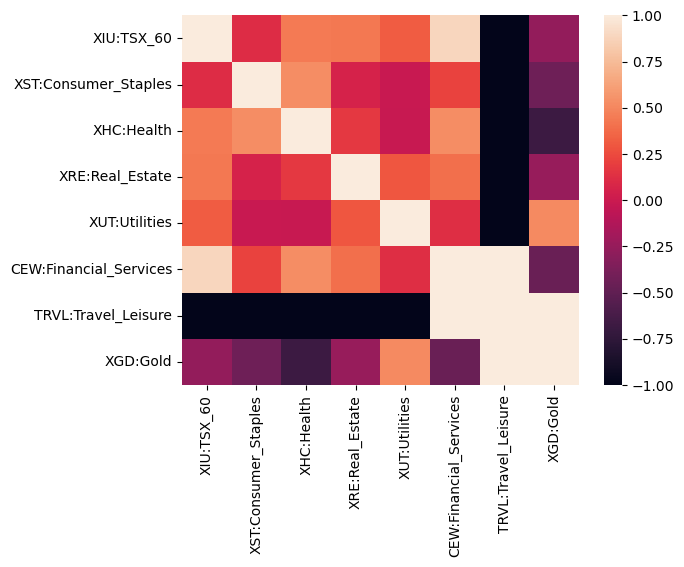

In [46]:
correlation = annual_returns.corr()
sns.heatmap(correlation)

In [63]:
annual_returns.hvplot(rot=90,width=200,height=200,subplots=True)

:NdLayout   [Variable]
   :Curve   [Year]   (value)

In [64]:
annual_returns.hvplot(kind='bar',rot=90,width=200,height=200,subplots=True)

:NdLayout   [Variable]
   :Bars   [Year]   (value)